# Assignment 4 - Vanilla RNN

## Libraries

In [7]:
import math

import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm.notebook import trange

In [8]:
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_properties(i).name)

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Data

In [9]:
book_fname = 'data/goblet_book.txt'
with open(book_fname, 'r') as f:
    book_data = f.read()
    f.close()

book_chars = list(set(book_data))
K = len(book_chars)
print(f"Number of unique characters: {K}")
char2ind, ind2char = dict(), dict()
for i, c in enumerate(book_chars):
    char2ind[c] = i
    ind2char[i] = c

Number of unique characters: 80


## Model

In [10]:
class RNN:

    def __init__(self, m=100, seq_length=25, eta=.001, gamma=.9, sig=.01, device=device):
        self.m = m
        self.seq_length = seq_length
        self.eta = eta
        self.gamma = gamma
        self.device = device

        self.V = torch.randn(K, m).to(self.device) * sig
        self.c = torch.zeros(K, 1).to(self.device)
        self.W = torch.randn(m, m).to(self.device) * sig
        self.b = torch.zeros(m, 1).to(self.device)
        self.U = torch.randn(m, K).to(self.device) * sig

        self.V_g_ada = torch.zeros(K, m).to(self.device)
        self.c_g_ada = torch.zeros(K, 1).to(self.device)
        self.W_g_ada = torch.zeros(m, m).to(self.device)
        self.b_g_ada = torch.zeros(m, 1).to(self.device)
        self.U_g_ada = torch.zeros(m, K).to(self.device)

        self.V_best = self.V.clone()
        self.c_best = self.c.clone()
        self.W_best = self.W.clone()
        self.b_best = self.b.clone()
        self.U_best = self.U.clone()

        self.smooth_losses = list()

        self.grads = {
            'V': torch.zeros_like(self.V),
            'c': torch.zeros_like(self.c),
            'W': torch.zeros_like(self.W),
            'b': torch.zeros_like(self.b),
            'U': torch.zeros_like(self.U)
        }

    def synthesize(self, h_prev, x, n, best=False):
        Y = torch.zeros((K, n)).to(self.device)
        x_t = x
        for i in range(n):
            h_prev, p = self.forward(h_prev, x_t, best=best)
            cp = torch.cumsum(p, dim=0)
            r = torch.rand(1)
            for j in range(K):
                if r < cp[j]:
                    break
            Y[j, i] = 1
            x_t = torch.zeros((K, 1))
            x_t[j] = 1
        return Y

    def forward(self, h_prev, x, best=False):
        if not best:
            h = torch.tanh(self.W @ h_prev + self.U @ x + self.b)
            y = self.V @ h + self.c
            p = torch.softmax(y, dim=0)
        else:
            h = torch.tanh(self.W_best @ h_prev + self.U_best @ x + self.b_best)
            y = self.V_best @ h + self.c_best
            p = torch.softmax(y, dim=0)
        return h, p
    
    def forward_pass(self, h_0, X, Y, best=False):
        h = h_0
        H = torch.zeros((self.m, self.seq_length + 1)).to(self.device)
        P = torch.zeros((K, self.seq_length)).to(self.device)
        H[:, 0] = h.flatten()
        loss = 0
        for i in range(self.seq_length):
            h, p = self.forward(h, X[:, i].reshape(K, 1), best=best)
            H[:, i+1] = h.flatten()
            P[:, i] = p.flatten()
            loss += self.loss(p, Y[:, i].reshape(K, 1))
        return H, P, loss

    def backward_pass(self, H, P, X, Y):
        self.grads = {
            'V': torch.zeros_like(self.V),
            'c': torch.zeros_like(self.c),
            'W': torch.zeros_like(self.W),
            'b': torch.zeros_like(self.b),
            'U': torch.zeros_like(self.U)
        }
        dL_dh_next = torch.zeros((self.m, 1)).to(self.device)
        h0 = H[:, 0].reshape(self.m, 1)
        H = H[:, 1:]
        for i in range(self.seq_length-1, -1, -1):
            x = X[:, i].reshape(K, 1)
            y = Y[:, i].reshape(K, 1)
            h = H[:, i].reshape(self.m, 1)
            p = P[:, i].reshape(K, 1)
            g = (p - y).T
            self.grads['V'] += g.T @ h.T
            self.grads['c'] += g.T
            dL_dh = self.V.T @ g.T + self.W.T @ dL_dh_next
            dL_dh_next = dL_dh * (1 - h ** 2)
            self.grads['W'] += dL_dh_next @ H[:, i-1].reshape(1, self.m) if i != 0 else dL_dh_next @ h0.T
            self.grads['b'] += dL_dh_next
            self.grads['U'] += dL_dh_next @ x.T
    
    def update_params(self, eps=1e-16):
        for key in self.grads.keys():
            vars(self)[key + '_g_ada'] = self.gamma * vars(self)[key + '_g_ada'] + (1 - self.gamma) * self.grads[key] ** 2
            vars(self)[key] -= self.eta * self.grads[key] / torch.sqrt(vars(self)[key + '_g_ada'] + eps)


    def loss(self, p, y):
        return - torch.sum(y.T @ torch.log(p))

    def train(self, book_data, n_epochs=7, eps=1e-16):
        n_iter = 0
        smooth_loss = 0
        best_loss = torch.inf
        pbar = trange(n_epochs)
        for epoch in pbar:
            pbar.set_description(f"Epoch {epoch}/{n_epochs}")
            self.e = 0
            h = torch.zeros((self.m, 1)).to(self.device)
            while self.e + self.seq_length <= len(book_data):
                X_chars = book_data[self.e:self.e+self.seq_length]
                Y_chars = book_data[self.e+1:self.e+self.seq_length+1]
                X = torch.zeros((K, self.seq_length)).to(self.device)
                Y = torch.zeros((K, self.seq_length)).to(self.device)
                for i in range(self.seq_length):
                    X[char2ind[X_chars[i]], i] = 1
                    Y[char2ind[Y_chars[i]], i] = 1

                H, P, loss = self.forward_pass(h, X, Y)
                self.backward_pass(H, P, X, Y)
                self.update_params(eps)

                smooth_loss = .999 * smooth_loss + .001 * loss if smooth_loss != 0 else loss
                self.smooth_losses.append(smooth_loss)

                if loss < best_loss:
                    best_loss = loss
                    self.V_best = self.V.clone()
                    self.c_best = self.c.clone()
                    self.W_best = self.W.clone()
                    self.b_best = self.b.clone()
                    self.U_best = self.U.clone()

                h = H[:, -1].reshape(self.m, 1)

                n_iter += 1
                if n_iter % 1000 == 0:
                    print(
                        f"Training - Iteration {n_iter} - Loss {smooth_loss}")
                    
                if n_iter % 10000 == 0:
                    Y = self.synthesize(h, X[:, 0].reshape(K, 1), 200)
                    print()
                    print(''.join([ind2char[torch.argmax(Y[:, i]).item()] for i in range(200)]))
                    print()

                self.e += self.seq_length

        print(f"Training done - Best loss: {best_loss}")

    def check_grads(self, book_data):
        for key in self.grads.keys():
            vars(self)[key].requires_grad = True

        X_chars = book_data[:self.seq_length]
        Y_chars = book_data[1:self.seq_length+1]
        X = torch.zeros((K, self.seq_length)).to(self.device)
        Y = torch.zeros((K, self.seq_length)).to(self.device)
        h0 = torch.zeros((self.m, 1)).to(self.device)
        for i in range(self.seq_length):
            X[char2ind[X_chars[i]], i] = 1
            Y[char2ind[Y_chars[i]], i] = 1

        H, P, loss = self.forward_pass(h0, X, Y)
        self.backward_pass(H, P, X, Y)

        for key in self.grads.keys():
            vars(self)[key].retain_grad()
        loss.backward()

        print("Checking gradients")
        with torch.no_grad():
            for key in self.grads.keys():
                diff = torch.norm(self.grads[key] - vars(self)[key].grad)
                rel_err = diff / (torch.norm(self.grads[key]) + torch.norm(vars(self)[key].grad) + 1e-16)
                print(f"Relative error on {key}: {rel_err}")

    def plot_losses(self):
        plt.plot(self.smooth_losses)
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Smoothed loss')
        plt.show()

In [11]:
rnn = RNN()
rnn.check_grads(book_data)

Checking gradients
Relative error on V: 3.033169448940498e-08
Relative error on c: 1.6266680447074577e-08
Relative error on W: 4.540372344763455e-08
Relative error on b: 3.466666953499953e-08
Relative error on U: 3.088153022190454e-08


In [12]:
rnn = RNN()
rnn.train(book_data, n_epochs=10)

  0%|          | 0/7 [00:00<?, ?it/s]

Training - Iteration 1000 - Loss 84.24493408203125
Training - Iteration 2000 - Loss 70.32706451416016
Training - Iteration 3000 - Loss 63.210994720458984
Training - Iteration 4000 - Loss 60.10073471069336
Training - Iteration 5000 - Loss 58.30186080932617
Training - Iteration 6000 - Loss 57.72549057006836
Training - Iteration 7000 - Loss 57.41823196411133
Training - Iteration 8000 - Loss 55.115230560302734
Training - Iteration 9000 - Loss 54.269187927246094
Training - Iteration 10000 - Loss 54.042755126953125

crimem the roems herarathe fay mumt ou for.. . ood Harmion.  A's 'ver said s notuld dap teey , . 
Mm. Weaglly kly, ay.
"Pratied ,""Hemrint it sbe lits, y !"
"Harry yin stoon that snem, and therryony o

Training - Iteration 11000 - Loss 54.643150329589844
Training - Iteration 12000 - Loss 53.960411071777344
Training - Iteration 13000 - Loss 53.06050491333008
Training - Iteration 14000 - Loss 52.220428466796875
Training - Iteration 15000 - Loss 52.26956558227539
Training - Iteratio

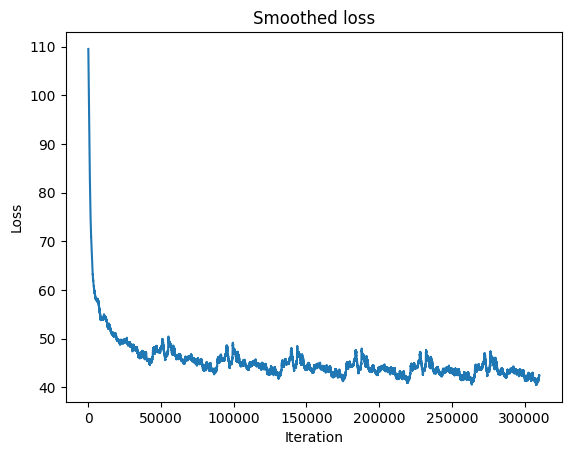

In [13]:
rnn.plot_losses()

In [14]:
starting_char = 'H'
X = torch.zeros((K, 1)).to(device)
X[char2ind[starting_char], 0] = 1
h = torch.zeros((rnn.m, 1)).to(device)
Y = rnn.synthesize(h, X, 1000, best=True)
print(starting_char + ''.join([ind2char[torch.argmax(Y[:, i]).item()] for i in range(1000)]))

arry, lon't cittred thoughtereath her shared the tangutch here,  oe's gone in they're was suently dasg becosven howe-f Muggory somenoring. " ill of they didn't been lost us emblant tond going to harry hoy preby, nowd. "em's powk whetrepred of would they' he'me as tis nith?r flats of it washing into his lons eyen a hafter, . . . "we srain.
"choilt he repoing dose he toke "
"uf was scorted and blinction.  The supps ofraid for," said reat of Mr. Muof ce, it's fating track
"I have rearlling him. . ." oate, at the siHarry, liken flows and he the pit of them.  "'s goits were for it fore when they add never they' repoars them, they'r my, behindout they donen," beard knogart as folding untors.  "now he hundinly teblo cooding on off don't his thot had nowd whot then youdd themn whill use like to than the ploters him Mr.
"Werone back, been palf.  fcate whing it did in the sound.shere lest'linneched an coaded. , them olle rut they find off her," sied tonsurid them sheating from onech, as therofee